<a href="https://colab.research.google.com/github/dennisWu67/airbnb-data-analysis/blob/main/DSProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

#Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from google.colab import drive


drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/nyc_kaggle/AB_NYC_2019.csv')
print("Shape:", df.shape)
display(df.head())


Mounted at /content/drive
Shape: (48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Understanding the Data


MISSING VALUES (count)


,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


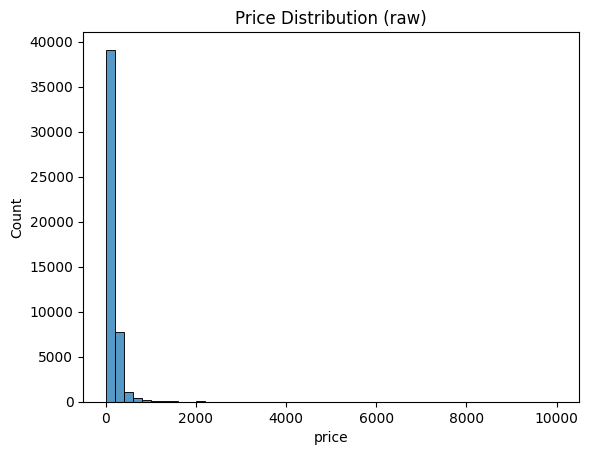

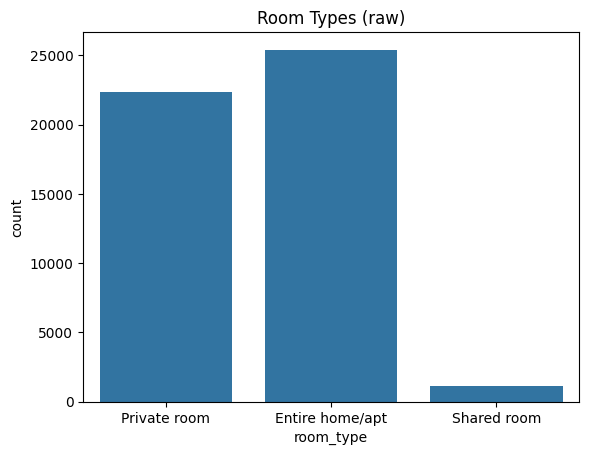

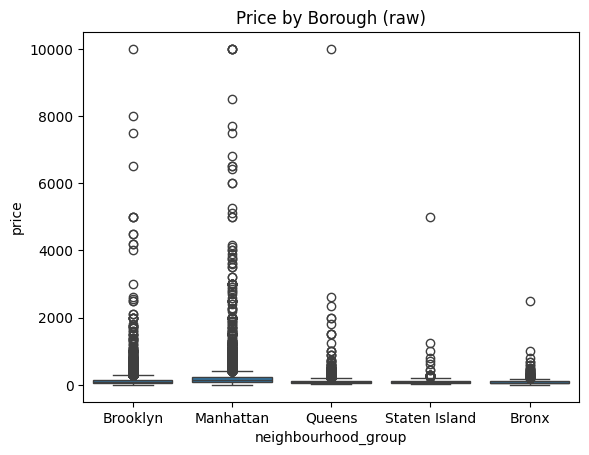

In [5]:
print("\nMISSING VALUES (count)")
display(df.isnull().sum())

# Price distribution
sns.histplot(df['price'], bins=50)
plt.title("Price Distribution (raw)")
plt.show()

# Room type counts
sns.countplot(x='room_type', data=df)
plt.title("Room Types (raw)")
plt.show()

#Price by borough
sns.boxplot(x='neighbourhood_group', y='price', data=df)
plt.title("Price by Borough (raw)")
plt.show()


# Cleaning Data Part1

---



In [6]:
df.info()

df = df.drop_duplicates()

df.isnull().sum()
df['last_review'] = df['last_review'].fillna('No Date')
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
print("\nMissing value after cleaning\n", df.isnull().sum())

#df = df.drop(['id', 'host_id', 'name', 'host_name'], axis=1)

df = df[df['price'] > 0]
df = df[df['price'] < 1000]
print("\nPrice Range after cleaning")
print("\nMin Price:", df['price'].min())
print("\nMax Price:", df['price'].max())

text_cols = ['neighbourhood', 'neighbourhood_group', 'room_type']
for col in text_cols:
    df[col] = df[col].str.lower()
    df[col] = df[col].str.strip()
for col in text_cols:
    df[col] = df[col].str.title()

print("\nUnique values after cleaning:")
for col in text_cols:
    print(f"\n{col}:")
    print(df[col].unique()[:10])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

# Cleaning Data Part2

In [7]:
print("\nReview Last week's Cleaning")
print("Shape of Current Shape:", df.shape)
print("Missing values per column:")
display(df.isnull().sum())

cols = [
    'price',
    'neighbourhood_group',
    'room_type',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

existing = [c for c in cols if c in df.columns]
df_model = df[existing].dropna()

print("\nColumns kept for modeling:")
print(existing)
print("Shape after selecting columns:", df_model.shape)
display(df_model.head())


Review Last week's Cleaning
Shape of Current Shape: (48586, 16)
Missing values per column:


,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0



Columns kept for modeling:
['price', 'neighbourhood_group', 'room_type', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
Shape after selecting columns: (48586, 10)


,price,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,149,Brooklyn,Private Room,40.64749,-73.97237,1,9,0.21,6,365
1,225,Manhattan,Entire Home/Apt,40.75362,-73.98377,1,45,0.38,2,355
2,150,Manhattan,Private Room,40.80902,-73.94190,3,0,0.00,1,365
3,89,Brooklyn,Entire Home/Apt,40.68514,-73.95976,1,270,4.64,1,194
4,80,Manhattan,Entire Home/Apt,40.79851,-73.94399,10,9,0.10,1,0


# Define X and Y

In [8]:
try:
    print("df_model found. Shape:", df_model.shape)
except NameError:
    raise RuntimeError("df_model not found. Run your Week 3 code first to create df_model.")

# STEP 1: Define Features (x) and Target (y)
target = 'price'

# Columns that will be used as features
features = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews', 'reviews_per_month',
    'calculated_host_listings_count', 'availability_365'
]

# Create x (features) and y (target)
X = df_model[features]
y = df_model[target]

print("\nFeatures and target defined.")
print("X shape:", X.shape)
print("y shape:", y.shape)

df_model found. Shape: (48586, 10)

Features and target defined.
X shape: (48586, 9)
y shape: (48586,)


# Train/Test Split

In [9]:
from sklearn.model_selection import train_test_split

# Split 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nData split complete:")
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Preview to confirm split worked
print("\nTraining set preview:")
display(X_train.head())

print("\nTesting set preview:")
display(X_test.head())


Data split complete:
Training set shape: (38868, 9)
Testing set shape: (9718, 9)

Training set preview:


,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
38612,Brooklyn,Private Room,40.69998,-73.94369,1,5,0.71,2,0
27308,Brooklyn,Entire Home/Apt,40.69723,-73.92244,2,44,2.15,4,352
39218,Manhattan,Private Room,40.72176,-73.98825,1,8,2.07,3,0
44256,Manhattan,Entire Home/Apt,40.74269,-73.99911,30,0,0.00,232,323
226,Brooklyn,Private Room,40.65850,-73.98397,2,21,0.26,1,272



Testing set preview:


,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
34313,Brooklyn,Private Room,40.68589,-73.94762,2,21,2.04,4,334
16050,Queens,Private Room,40.72103,-73.89458,1,30,0.78,3,364
14852,Manhattan,Entire Home/Apt,40.77815,-73.96158,1,0,0.00,1,0
5753,Manhattan,Entire Home/Apt,40.74643,-73.97536,1,1,0.02,1,0
39367,Brooklyn,Entire Home/Apt,40.61843,-73.95626,3,1,0.25,1,0


# Model Traning 1 - Linear Regression


In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Identify which columns are categorical (the ones with strings)
cat_cols = ['neighbourhood_group', 'room_type']

# Preprocessing: One-hot encode only the categorical columns
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'   # keep numeric columns as they are
)

# Build pipeline: preprocess → linear regression model
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('linreg', LinearRegression())
])

# Train the model
model.fit(X_train, y_train)
print("\nModel training complete.")

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance (Linear Regression):")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R² Score:", round(r2, 4))

# Show sample predictions
results_preview = pd.DataFrame({
    'Actual Price': y_test[:10].values,
    'Predicted Price': y_pred[:10]
})

print("\nSample Predictions (first 10):")
display(results_preview)

sample = X_test.head(10).copy()
sample['Actual Price'] = y_test[:10].values
sample['Predicted Price'] = y_pred[:10]

display(sample)


Model training complete.

Model Performance (Linear Regression):
MAE: 56.21
RMSE: 93.55
R² Score: 0.3182

Sample Predictions (first 10):


,Actual Price,Predicted Price
0,65,104.142340
1,60,101.990681
2,400,200.000384
3,200,209.790408
4,75,170.965121
5,50,95.552388
6,52,123.811443
7,126,151.331970
8,29,12.332452
9,33,71.991593


,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Actual Price,Predicted Price
34313,Brooklyn,Private Room,40.68589,-73.94762,2,21,2.04,4,334,65,104.142340
16050,Queens,Private Room,40.72103,-73.89458,1,30,0.78,3,364,60,101.990681
14852,Manhattan,Entire Home/Apt,40.77815,-73.96158,1,0,0.00,1,0,400,200.000384
5753,Manhattan,Entire Home/Apt,40.74643,-73.97536,1,1,0.02,1,0,200,209.790408
39367,Brooklyn,Entire Home/Apt,40.61843,-73.95626,3,1,0.25,1,0,75,170.965121
43435,Brooklyn,Private Room,40.66008,-73.92122,2,5,2.50,1,304,50,95.552388
14668,Manhattan,Private Room,40.71303,-73.98645,1,0,0.00,1,0,52,123.811443
6869,Brooklyn,Entire Home/Apt,40.70083,-73.91679,3,98,1.95,1,180,126,151.331970
23571,Brooklyn,Shared Room,40.69510,-73.92983,1,124,4.99,7,73,29,12.332452
28341,Brooklyn,Private Room,40.67471,-73.88905,3,56,3.19,8,305,33,71.991593


# Model Traning 2 - KNN

In [11]:
# Second Model: K-Nearest Neighbors (KNN) Regression
# Uses the same X_train, X_test, y_train, y_test, and `preprocess` as before.

from sklearn.neighbors import KNeighborsRegressor

# Build pipeline: preprocess → KNN model
knn_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

# Train the model
knn_model.fit(X_train, y_train)
print("\nKNN model training complete.")

# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("\nModel Performance (KNN Regression):")
print("MAE:", round(mae_knn, 2))
print("RMSE:", round(rmse_knn, 2))
print("R² Score:", round(r2_knn, 4))

# Show sample predictions
results_preview_knn = pd.DataFrame({
    'Actual Price': y_test[:10].values,
    'Predicted Price (KNN)': y_pred_knn[:10]
})

print("\nSample Predictions (first 10) – KNN:")
display(results_preview_knn)

sample_knn = X_test.head(10).copy()
sample_knn['Actual Price'] = y_test[:10].values
sample_knn['Predicted Price (KNN)'] = y_pred_knn[:10]

display(sample_knn)



KNN model training complete.

Model Performance (KNN Regression):
MAE: 65.96
RMSE: 104.9
R² Score: 0.1429

Sample Predictions (first 10) – KNN:


,Actual Price,Predicted Price (KNN)
0,65,155.2
1,60,227.2
2,400,251.6
3,200,226.0
4,75,137.0
5,50,252.6
6,52,71.0
7,126,102.2
8,29,124.0
9,33,83.8


,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Actual Price,Predicted Price (KNN)
34313,Brooklyn,Private Room,40.68589,-73.94762,2,21,2.04,4,334,65,155.2
16050,Queens,Private Room,40.72103,-73.89458,1,30,0.78,3,364,60,227.2
14852,Manhattan,Entire Home/Apt,40.77815,-73.96158,1,0,0.00,1,0,400,251.6
5753,Manhattan,Entire Home/Apt,40.74643,-73.97536,1,1,0.02,1,0,200,226.0
39367,Brooklyn,Entire Home/Apt,40.61843,-73.95626,3,1,0.25,1,0,75,137.0
43435,Brooklyn,Private Room,40.66008,-73.92122,2,5,2.50,1,304,50,252.6
14668,Manhattan,Private Room,40.71303,-73.98645,1,0,0.00,1,0,52,71.0
6869,Brooklyn,Entire Home/Apt,40.70083,-73.91679,3,98,1.95,1,180,126,102.2
23571,Brooklyn,Shared Room,40.69510,-73.92983,1,124,4.99,7,73,29,124.0
28341,Brooklyn,Private Room,40.67471,-73.88905,3,56,3.19,8,305,33,83.8


# Model Traning 3 - Decision Tree

In [12]:
# Third Model: Decision Tree Regression

from sklearn.tree import DecisionTreeRegressor

# Build pipeline: preprocess → Decision Tree model
tree_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('tree', DecisionTreeRegressor(
        max_depth=5,       # you can adjust this
        random_state=42
    ))
])

# Train the model
tree_model.fit(X_train, y_train)
print("\nDecision Tree model training complete.")

# Make predictions
y_pred_tree = tree_model.predict(X_test)

# Evaluate the model
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print("\nModel Performance (Decision Tree Regression):")
print("MAE:", round(mae_tree, 2))
print("RMSE:", round(rmse_tree, 2))
print("R² Score:", round(r2_tree, 4))

# Show sample predictions
results_preview_tree = pd.DataFrame({
    'Actual Price': y_test[:10].values,
    'Predicted Price (Tree)': y_pred_tree[:10]
})

print("\nSample Predictions (first 10) – Decision Tree:")
display(results_preview_tree)

sample_tree = X_test.head(10).copy()
sample_tree['Actual Price'] = y_test[:10].values
sample_tree['Predicted Price (Tree)'] = y_pred_tree[:10]

display(sample_tree)


Decision Tree model training complete.

Model Performance (Decision Tree Regression):
MAE: 52.25
RMSE: 90.03
R² Score: 0.3686

Sample Predictions (first 10) – Decision Tree:


,Actual Price,Predicted Price (Tree)
0,65,74.627787
1,60,74.414397
2,400,171.909271
3,200,199.329670
4,75,131.166960
5,50,66.082774
6,52,103.165142
7,126,148.432599
8,29,66.082774
9,33,66.082774


,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Actual Price,Predicted Price (Tree)
34313,Brooklyn,Private Room,40.68589,-73.94762,2,21,2.04,4,334,65,74.627787
16050,Queens,Private Room,40.72103,-73.89458,1,30,0.78,3,364,60,74.414397
14852,Manhattan,Entire Home/Apt,40.77815,-73.96158,1,0,0.00,1,0,400,171.909271
5753,Manhattan,Entire Home/Apt,40.74643,-73.97536,1,1,0.02,1,0,200,199.329670
39367,Brooklyn,Entire Home/Apt,40.61843,-73.95626,3,1,0.25,1,0,75,131.166960
43435,Brooklyn,Private Room,40.66008,-73.92122,2,5,2.50,1,304,50,66.082774
14668,Manhattan,Private Room,40.71303,-73.98645,1,0,0.00,1,0,52,103.165142
6869,Brooklyn,Entire Home/Apt,40.70083,-73.91679,3,98,1.95,1,180,126,148.432599
23571,Brooklyn,Shared Room,40.69510,-73.92983,1,124,4.99,7,73,29,66.082774
28341,Brooklyn,Private Room,40.67471,-73.88905,3,56,3.19,8,305,33,66.082774


# Final

In [13]:

# Make sure needed objects exist
try:
    df_model, features, model, knn_model, tree_model
except NameError as e:
    raise RuntimeError("Make sure you have run all the cells above (df_model, features, model, knn_model, tree_model).") from e

# 1. Get valid options for the categorical columns
valid_neighbourhoods = sorted(df_model['neighbourhood_group'].dropna().unique())
valid_room_types = sorted(df_model['room_type'].dropna().unique())

# 2. Pre-compute average latitude/longitude per neighbourhood_group
avg_coords = df_model.groupby('neighbourhood_group')[['latitude', 'longitude']].mean()

print("Welcome to the Airbnb Price Predictor")
print("\nValid neighbourhood_group options:")
for n in valid_neighbourhoods:
    print(" -", n)

print("\nValid room_type options:")
for r in valid_room_types:
    print(" -", r)

print("\nType 'quit' at any time for neighbourhood_group to exit.\n")

# Small helper to safely read numeric input
def get_number(prompt, min_value=None, max_value=None):
    while True:
        text = input(prompt).strip()
        try:
            value = float(text)
            if min_value is not None and value < min_value:
                print(f"Please enter a value >= {min_value}.")
                continue
            if max_value is not None and value > max_value:
                print(f"Please enter a value <= {max_value}.")
                continue
            return value
        except ValueError:
            print("Please enter a valid number (e.g. 3 or 3.5).")

# 3. Main loop
while True:
    # --- Categorical inputs ---
    neigh = input("\nEnter neighbourhood_group (or 'quit' to stop): ").strip()
    if neigh.lower() == "quit":
        print("Exiting price predictor. Goodbye!")
        break

    if neigh not in valid_neighbourhoods:
        print("Invalid neighbourhood_group. Please choose from the list shown above.")
        continue

    room = input("Enter room_type: ").strip()
    if room not in valid_room_types:
        print("Invalid room_type. Please choose from the list shown above.")
        continue

    # Use the average latitude/longitude for that neighbourhood
    lat = avg_coords.loc[neigh, 'latitude']
    lon = avg_coords.loc[neigh, 'longitude']

    # --- Numeric inputs ---
    min_nights = get_number("Enter minimum_nights (>= 1): ", min_value=1)
    num_reviews = get_number("Enter number_of_reviews (>= 0): ", min_value=0)
    reviews_pm = get_number("Enter reviews_per_month (>= 0): ", min_value=0)
    host_count = get_number("Enter calculated_host_listings_count (>= 0): ", min_value=0)
    avail_365 = get_number("Enter availability_365 (0–365): ", min_value=0, max_value=365)

    # 4. Build a single-row DataFrame for prediction
    input_data = pd.DataFrame([{
        'neighbourhood_group': neigh,
        'room_type': room,
        'latitude': lat,
        'longitude': lon,
        'minimum_nights': min_nights,
        'number_of_reviews': num_reviews,
        'reviews_per_month': reviews_pm,
        'calculated_host_listings_count': host_count,
        'availability_365': avail_365
    }])

    # Make sure the columns are in the same order as the features we trained on
    input_data = input_data[features]

    # 5. Get predictions from all three models
    pred_lin = model.predict(input_data)[0]
    pred_knn = knn_model.predict(input_data)[0]
    pred_tree = tree_model.predict(input_data)[0]

    # 6. Show results (Decision Tree is the main one)
    print("\n--- Predicted Nightly Price (USD) ---")
    print(f"Decision Tree (best):      ${pred_tree:,.2f}")
    print(f"Linear Regression (middle): ${pred_lin:,.2f}")
    print(f"KNN (worst):                ${pred_knn:,.2f}")


Welcome to the Airbnb Price Predictor

Valid neighbourhood_group options:
 - Bronx
 - Brooklyn
 - Manhattan
 - Queens
 - Staten Island

Valid room_type options:
 - Entire Home/Apt
 - Private Room
 - Shared Room

Type 'quit' at any time for neighbourhood_group to exit.


Enter neighbourhood_group (or 'quit' to stop): Brooklyn
Enter room_type: Shared Room
Enter minimum_nights (>= 1): 2
Enter number_of_reviews (>= 0): 10
Enter reviews_per_month (>= 0): 10
Enter calculated_host_listings_count (>= 0): 5
Enter availability_365 (0–365): 50

--- Predicted Nightly Price (USD) ---
Decision Tree (best):      $74.63
Linear Regression (middle): $33.53
KNN (worst):                $111.00

Enter neighbourhood_group (or 'quit' to stop): quit
Exiting price predictor. Goodbye!
